In [1]:
import os

In [2]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 2 to use

In [3]:
import torch

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 1


In [5]:
import sys

sys.path.append('../GSL')

In [28]:
import matplotlib.pyplot as plt

from matplotlib.animation import FuncAnimation, PillowWriter

import pandas as pd
import numpy as np
import torch
from torch.nn import functional as F
import torch.nn as nn

from glob import glob, escape
import pickle
import yaml
from easydict import EasyDict as edict

from torch_geometric.utils import to_dense_adj, dense_to_sparse

from utils.scalers import *
from utils.score import *

In [29]:
exp_dirs = glob('../exp/0715_ECL*/*')
exp_dirs.sort()
exp_dirs

['../exp/0715_ECL_PN_BEATS/stacks_12__singular_stack_num_3__mlp_stack_1024x1_0715_001218',
 '../exp/0715_ECL_PN_BEATS/stacks_15__singular_stack_num_3__mlp_stack_1024x1_0715_001221',
 '../exp/0715_ECL_PN_BEATS/stacks_3__singular_stack_num_3__mlp_stack_1024x1_0715_001209',
 '../exp/0715_ECL_PN_BEATS/stacks_6__singular_stack_num_3__mlp_stack_1024x1_0715_001212',
 '../exp/0715_ECL_PN_BEATS/stacks_9__singular_stack_num_3__mlp_stack_1024x1_0715_001215']

In [30]:
exp = exp_dirs[2]

In [31]:
config_file = glob(escape(exp+'/config.yaml'))[0]
config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))

train_result_dirs = glob(escape(exp+'/training_result.pickle'))
train_result = pickle.load(open(train_result_dirs[0], 'rb'))

test_result_dirs = glob(escape(exp+'/test_result.pickle'))
test_result = pickle.load(open(test_result_dirs[0], 'rb'))

In [32]:
test_result['score']

{'scaled_score': {'MAE': 0.24157557,
  'MAPE': 0.5873455,
  'RMSE': 0.3955942523572513,
  'MSE': 0.15648481},
 'inv_scaled_score': {'MAE': 211.24872,
  'MAPE': 0.16516732,
  'RMSE': 2173.6008143194094,
  'MSE': 4724540.5}}

In [36]:
num_timesteps_in = config.forecasting_module.backcast_length
num_timesteps_out = config.forecasting_module.forecast_length
batch_size = config.train.batch_size
dataset_hyperparameter = f'{num_timesteps_in}_{num_timesteps_out}_{64}'

scaler = pickle.load(
                open(os.path.join(f'../GSL/data/ECL/temporal_signal_{dataset_hyperparameter}.pickle'), 'rb'))
scaler = scaler['scaler']

In [37]:
target = test_result['target']
pred = test_result['prediction']

inputs = test_result['Inputs']
backcast = test_result['backcast']
if config.forecasting_module.name == 'n_beats':
    stack_per_forecast = np.stack(test_result['stack_per_forecast'])
    stack_per_backcast = np.stack(test_result['stack_per_backcast'])

    block_per_backcast= test_result['block_per_backcast']
    block_per_forecast= test_result['block_per_forecast']
    
if config.forecasting_module.name == 'pn_beats':
    per_trend_backcast = test_result['per_trend_backcast']
    per_trend_forecast = test_result['per_trend_forecast']

    per_seasonality_backcast = test_result['per_seasonality_backcast']
    per_seasonality_forecast = test_result['per_seasonality_forecast']

    singual_backcast = test_result['singual_backcast']
    singual_forecast = test_result['singual_forecast']

In [15]:
cncat_target = target[:,:,0].swapaxes(1,0).reshape(25, -1)
cncat_pred = pred[:,:,0].swapaxes(1,0).reshape(25, -1)

inv_target = scaler.inv_scale(cncat_target)
inv_preds = scaler.inv_scale(cncat_pred)

In [21]:
start_date = pd.to_datetime('2020-03-22') ## 시작 날짜
end_date = pd.to_datetime('2020-5-03') ## 마지막 날짜
 
dates = pd.date_range(start_date,end_date,freq='D') ## 일단위로 생성
len(dates)

43

In [ ]:
%matplotlib notebook

x = []
y_2 = []
y_3 = []

_preds = tuple(inv_preds[node].tolist())
_targets = tuple(inv_target[node].tolist())

y_max = max(_preds + _targets) + 100
y_min = min(_preds + _targets) - 100


fig, ax = plt.subplots()


def animate(i):    
    x.append(dates[i])

    y_2.append(_preds[i])
    y_3.append(_targets[i])

    ax.clear()
#         ax.plot(x[i:],y_2, label='Target', color='#EC3100')
    ax.plot(x[:97],y, label='Input', color='#871C00')

    ax.plot(x[97:],y_2, label='Pred', color='#EC3100')
    ax.plot(x[97:],y_3, label='Target', color='#CDC0BC', alpha = 0.5)
    ax.legend(loc='upper right')
        
    ax.set_xlim([0,100*2])
    ax.set_ylim([y_min,y_max])
    
ani = FuncAnimation(fig, animate, frames=range(192), interval=5000, repeat=False)
ani.save('test.gif', writer='imagemagick', fps=30, dpi=100)
# ani.save('test.gif', dpi=80, writer=PillowWriter(fps=30))

plt.show()

<IPython.core.display.Javascript object>


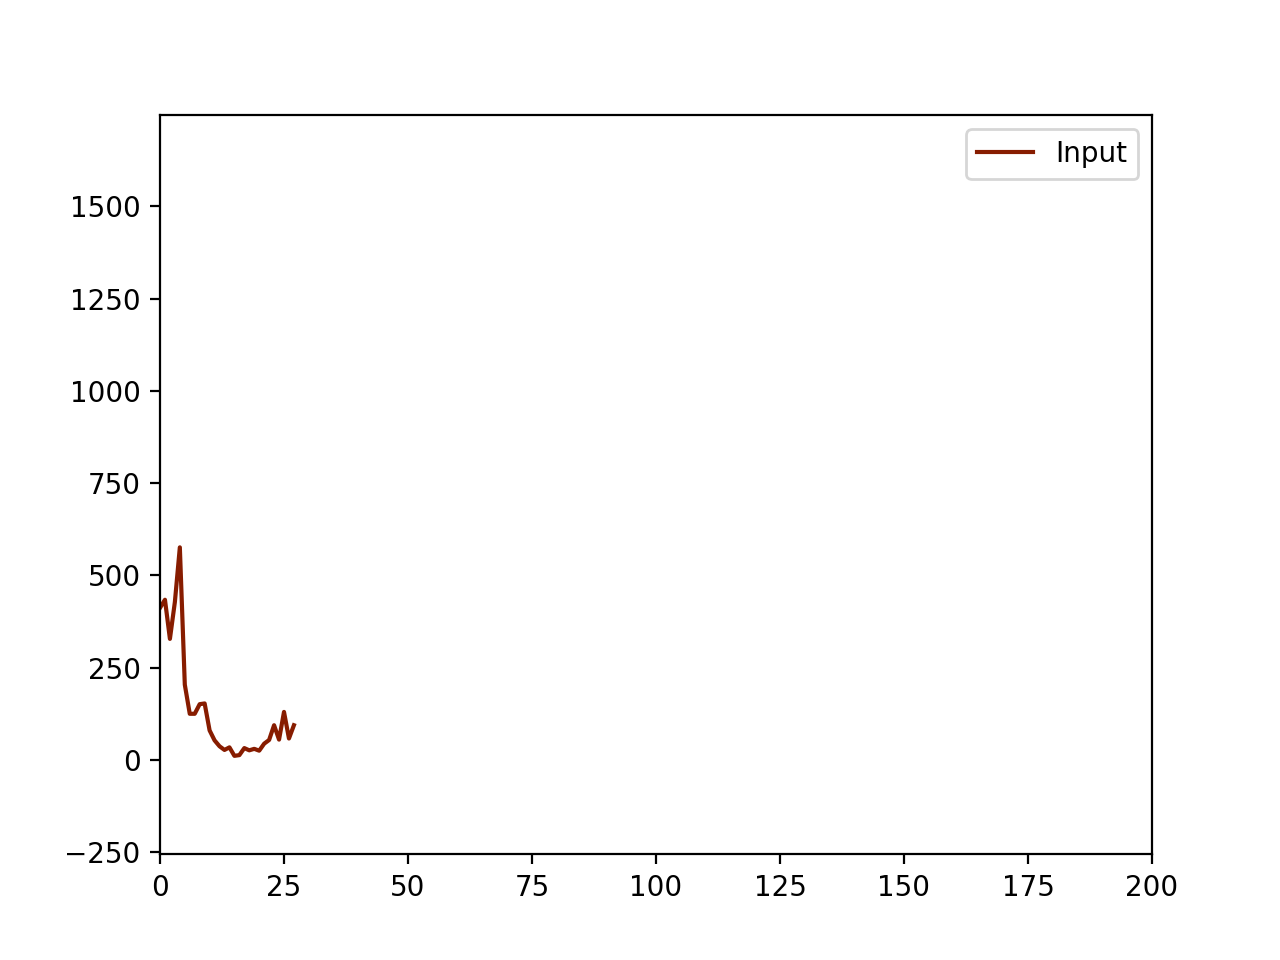

In [40]:
%matplotlib notebook

x = []
y = []
y_2 = []
y_3 = []

_inputs = tuple(inv_inputs[node].tolist())
_preds = tuple(inv_preds[node].tolist())
_targets = tuple(inv_target[node].tolist())

y_max = max(_inputs + _preds + _targets) + 100
y_min = min(_inputs + _preds + _targets) - 100


fig, ax = plt.subplots()


def animate(i):    
    x.append(i)
    
    if i < 96:
        y.append(_inputs[i])
        
        ax.clear()
        ax.plot(x,y, label='Input', color='#871C00')
        ax.legend(loc='upper right')
        
    elif i >= 96:
        y_2.append(_preds[i-96])
        y_3.append(_targets[i-96])
        
        ax.clear()
#         ax.plot(x[i:],y_2, label='Target', color='#EC3100')
        ax.plot(x[:97],y, label='Input', color='#871C00')
    
        ax.plot(x[97:],y_2, label='Pred', color='#EC3100')
        ax.plot(x[97:],y_3, label='Target', color='#CDC0BC', alpha = 0.5)
        ax.legend(loc='upper right')
        
    ax.set_xlim([0,100*2])
    ax.set_ylim([y_min,y_max])
    
ani = FuncAnimation(fig, animate, frames=range(192), interval=5, repeat=False)
# ani.save('test.gif', writer='imagemagick', fps=30, dpi=100)
# ani.save('test.gif', dpi=80, writer=PillowWriter(fps=30))

plt.show()